In [1]:
import pandas as pd; pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
from datetime import datetime
import warnings; warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
from ipywidgets import AppLayout, Button, Layout, VBox, HBox, Label, HTML, interact, IntSlider
import ipywidgets as widgets
import arrow

#import dmyplant2
from dmyplant2 import (
    cred, MyPlant, Engine, 
    msgFSM, filterFSM, FSMPlot_Start, 
    bokeh_show, dbokeh_chart, add_dbokeh_vlines, get_cycle_data2, 
    disp_result, alarms_pareto, warnings_pareto, states_lines,
    detect_edge_right, detect_edge_left)
    
cred()
mp = MyPlant(3600)
Engine._list_cached_validations();

In [23]:
def sfun(x):
     return all([ (x['Engine Type'] == '920'),  (x['OperationalCondition'] != 'Decommissioned') ])
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
#fleet = mp.search_installed_fleet_by_contains_name("920")
#fleet = mp.get_installed_fleet()
fleet = fleet.sort_values(by = ['IB Site Name','Engine ID','Count_OpHour'],ascending=[True,True,False]).reset_index(drop='index')
fleet.head(1).T;
fleet[['IB Site Name','Engine ID','Engine Version','IB NOX','Power_PowerNominal','Engine Type','Country','Count_OpHour','startup_counter','OperationalCondition','id','serialNumber','Commissioning Date','IB Status','IB Item Description Engine']]

,IB Site Name,Engine ID,Engine Version,IB NOX,Power_PowerNominal,Engine Type,Country,Count_OpHour,startup_counter,OperationalCondition,id,serialNumber,Commissioning Date,IB Status,IB Item Description Engine
0,BHKW MERHEIM,M01,C101,500,10387.0,920,DE,7539.0,468.0,Available,134609,1405614,2020-04-30,Active Docu incomplete,ENG JMS 920 C101 50__J_Y647
1,BHKW MERHEIM,M02,C101,500,10387.0,920,DE,10412.0,450.0,Available,135246,1405664,2020-04-30,Active Docu incomplete,ENG JMS 920 C101 50__J_Y648
2,BHKW MERHEIM,M03,C101,500,10387.0,920,DE,8138.0,472.0,Available,135675,1405727,2020-04-30,Active Docu incomplete,ENG JMS 920 C101 50__J_Y649
3,BHKW Stapelfeld,M01,A101,500,9513.0,920,DE,15810.0,1593.0,Running,97665,1221743,2015-12-04,Active,ENG JMS 920 A101 50__J_M163
4,Fernwärme Ulm,M01,C101,500,NaN,920,DE,NaN,NaN,Never Connected,154325,1472708,NaN,Not Commissioned,ENG JMS 920 C101 50__J_Z075
5,Fernwärme Ulm,M02,C101,500,NaN,920,DE,NaN,NaN,Never Connected,136671,1427893,NaN,Not Commissioned,ENG JMS 920 C101 50__J_Z076
6,GHKW KIEL,M1830,A101,180/500,9571.0,920,DE,9866.0,1263.0,Tripped,117057,1172721,2019-11-28,Active Docu incomplete,ENG JMS 920 A101 50__J_T843
7,GHKW KIEL,M1831,A101,180/500,9571.0,920,DE,10255.0,1214.0,Available,117002,1174165,2019-11-28,Active Docu incomplete,ENG JMS 920 A101 50__J_T943
8,GHKW KIEL,M1832,A101,180/500,9571.0,920,DE,10087.0,1233.0,Available,117081,1173991,2019-11-28,Active Docu incomplete,ENG JMS 920 A101 50__J_T942
9,GHKW KIEL,M1833,A101,180/500,9571.0,920,DE,12650.0,1319.0,Running,117912,1174000,2019-11-28,Active Docu incomplete,ENG JMS 920 A101 50__J_T941


In [28]:
motor = fleet.iloc[39]
modes = ['???','OFF','MANUAL','AUTO']; modes = ['AUTO'];
success = [True,False]; success = [True]
motor['IB Site Name'] + ' ' + motor['Engine ID'], modes, success

('HKW Pforzheim M04', ['AUTO'], [True])

In [37]:
e=Engine.from_fleet(mp,motor)
#fsm = msgFSM(e, p_from=e['Commissioning Date'], p_to=datetime.now(), successtime=300)
fsm = msgFSM(e, p_from="2021-10-01", successtime=300)
#fsm = msgFSM(e, p_to='2022-02-01', successtime=600)
#fsm = msgFSM(e, p_from='2022-01-26', p_to='2022-02-01', successtime=600)
fsm.run1(enforce=True) # run Finite State Machine

FSM: 100%|███████████████████████| 28986/28986 [00:22<00:00, 1305.08 messages/s]


In [38]:
rdf = fsm.starts
rda = rdf[:].reset_index(drop='index')
rda = rda[(rda['mode'].isin(modes) & rda['success'].isin(success))].reset_index(drop='index')
display(HTML(pd.DataFrame.from_dict(e.dash, orient='index').T.to_html(escape=False, index=False)))
print(f"Starts: {rdf.shape[0]}, Successful: {rdf[rdf['success'] == True].shape[0]}, Failed: {rdf[rdf['success'] == False].shape[0]} => {rdf[rdf['success'] == True].shape[0]/rdf.shape[0]*100.0:3.1f}%")

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>Na…

Starts: 152, Successful: 122, Failed: 30 => 80.3%


In [39]:
rda[filterFSM.run2filter_content].round(2).fillna('')

,no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
0,1,True,AUTO,60.40,5.78,18.05,,67.00,277.78,429.007997,,,2239.00,120.94,0.0,89.86,0.0,3.0
1,3,True,AUTO,60.34,5.57,17.16,,11.56,277.78,372.403999,,,53648.34,138.99,0.0,91.85,0.0,5.0
2,4,True,AUTO,60.37,5.67,14.77,,20.51,277.78,379.096998,,,24890.28,155.90,0.0,91.77,0.0,3.0
3,5,True,AUTO,60.45,5.77,15.61,,7.21,277.78,366.812997,,,7154.94,143.25,0.0,91.92,0.0,2.0
4,6,True,AUTO,60.37,5.38,14.22,,21.04,277.78,378.792997,,,21198.21,95.65,0.0,91.88,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,146,True,AUTO,56.57,5.75,13.33,,12.56,277.78,365.982998,,,23240.52,80.20,0.0,90.78,0.0,1.0
116,147,True,AUTO,60.42,5.15,13.78,,42.22,277.78,399.345998,,,28556.04,180.40,0.0,90.99,0.0,0.0
117,148,True,AUTO,60.43,5.27,13.49,,32.86,277.78,389.826998,,,26293.47,132.99,0.0,90.95,0.0,3.0
118,149,True,AUTO,60.44,5.16,13.63,,59.09,277.78,416.101998,,,8979.40,220.33,0.0,90.98,0.0,2.0


In [44]:
#rdb = rda[(rda['mode'].isin(['AUTO','MANUAL'])) & ((rda['count_alarms'] > 0) | (rda['count_warnings'] > 0))]
#rdb = rda[rda['synchronize'] < 15.0]
#rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2)
rdb = rda

,startpreparation,speedup,synchronize,loadramp,rampdown,runout
count,120.00,120.00,120.00,120.00,120.00,114.00
mean,73.19,20.82,25.99,277.78,113.09,91.46
std,62.65,46.62,14.40,0.00,47.64,0.77
min,5.25,11.89,1.42,277.78,0.10,88.26
25%,60.35,13.75,15.80,277.78,80.92,91.22
50%,60.40,14.45,21.18,277.78,120.46,91.63
75%,60.45,15.57,34.81,277.78,144.32,91.92
max,375.91,395.21,67.00,277.78,220.33,92.46


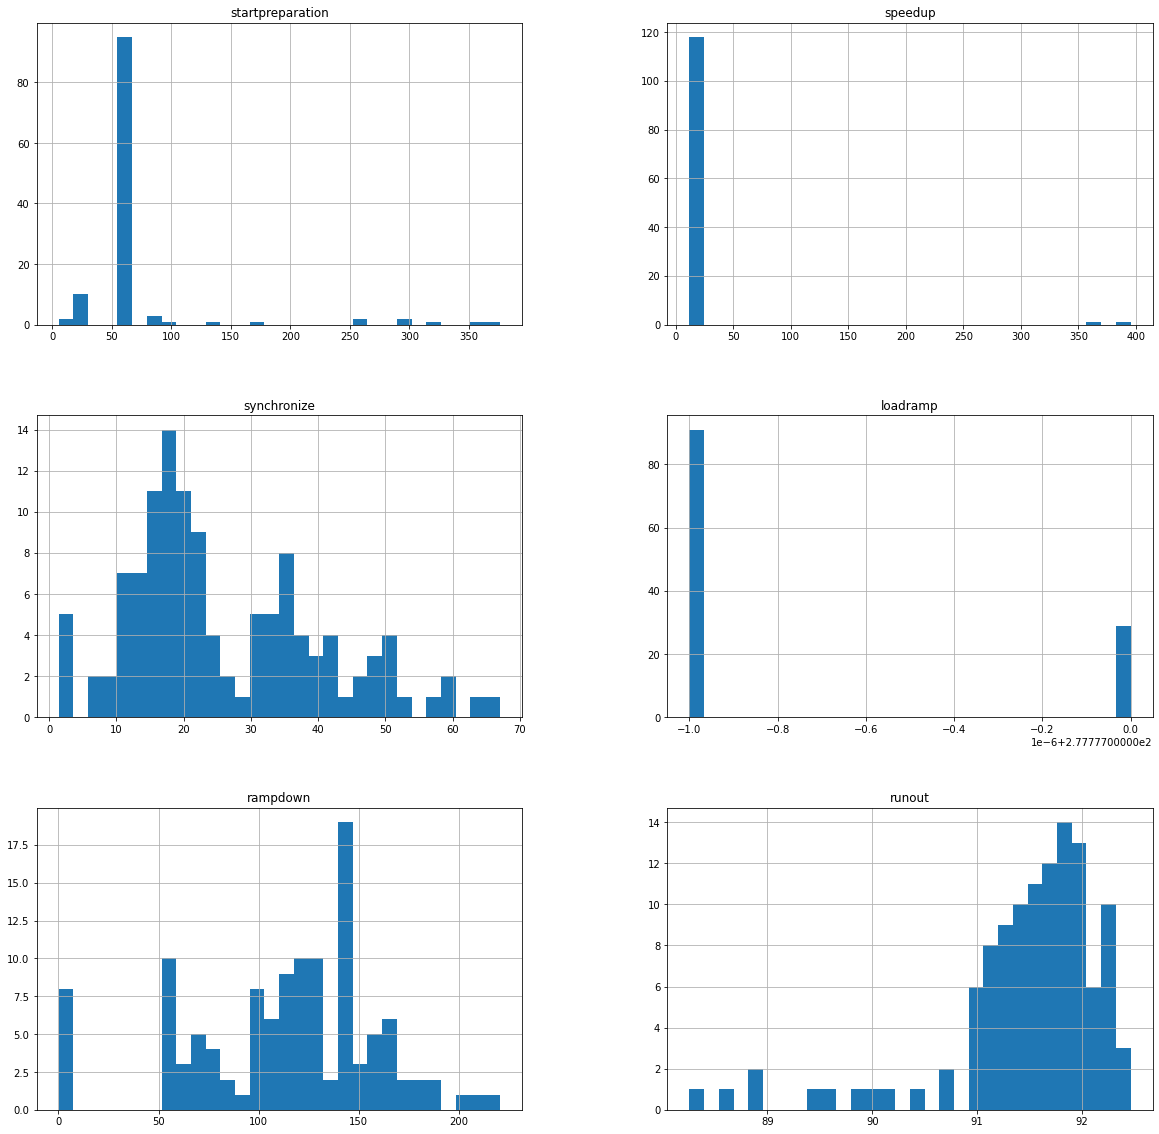

In [47]:
#vec = ['startpreparation','speedup','idle','synchronize','loadramp','maxload','ramprate','cumstarttime','targetoperation','rampdown','coolrun','runout']
vec = ['startpreparation','speedup','synchronize','loadramp','cumstarttime','rampdown','runout']
display(_=rdb[vec].hist(bins=30,figsize=(20,20)))
display(rdb[vec].describe().round(2))

In [48]:
rde = rda[(rda.starttime > fsm._e['Commissioning Date']) & (rda['success'])].copy()
rde['datetime'] = pd.to_datetime(rde['starttime'])
dfigsize = (18,10)
dset = [
    {'col':['cumstarttime'],'ylim':(-400,900), 'color':'darkblue'},
    {'col':['synchronize'],'ylim':(-20,300)},
    {'col':['startpreparation'],'ylim':(-600,300)},
    {'col':['hochlauf'],'ylim':(-100,200), 'color':'orange'},
    {'col':['loadramp'],'ylim':(-150,900), 'color':'red'},
    {'col':['ramprate'],'ylim':(-3,3)},
    {'col':['no'],'ylim':(-100,10000),'color':'black'},
    {'col':['maxload'],'ylim':(500,5000) }
]
ftitle = f"{fsm._e}"
fig = dbokeh_chart(rde, dset, style='both', figsize=dfigsize ,title=ftitle);
bokeh_show(fig)

In [50]:
vset = ['Various_Values_SpeedAct','Power_PowerAct','Exhaust_TempCylMax','Exhaust_TempCylMin','Hyd_PressCrankCase','Hyd_PressOilDif','TecJet_Lambda1','Hyd_PressOil','Hyd_TempOil']
dset = [
    {'col':['Power_PowerAct'], '_ylim':(0,5000), 'color':'red'},
    {'col':['power_diff'], '_ylim':(0,5000), 'color':'purple'},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500], 'color':'blue'},
    {'col':['Exhaust_TempCylMax'],'_ylim': [0, 2500], 'color':'red'},
    {'col':['Exhaust_TempCylMin'],'_ylim': [0, 2500], 'color':'red'},
    {'col':['Hyd_PressCrankCase'],'ylim': [-100, 100], 'color':'orange'},
    {'col':['Hyd_PressOilDif'],'ylim': [0, 2], 'color':'black'},
    {'col':['TecJet_Lambda1'],'_ylim': [0, 2], 'color':'green'},
    {'col':['Hyd_PressOil'],'_ylim': [0, 10], 'color':'brown'},
    {'col':['Hyd_TempOil'],'_ylim': [0, 110], 'color':'#2171b5'}
]


In [54]:
#rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2).fillna('')

In [55]:
def f(x=0):
    global v; v = x; startversuch = rdb.iloc[x]
    ftitle = f"{fsm._e} ----- Start {startversuch['no']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
    display(HTML(ftitle));
    disp_result(startversuch)
interact(f, x = IntSlider(0, 0, rdb.shape[0]-1 , 1, layout=widgets.Layout(width='70%')));

interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='70%'), max=119), Output()), _do…

In [59]:
from dowork import plot_now
inerestingstarts_pforzheim_m4 = [41,42,54,67,68,69,70]
inerestingstarts_merheim_m1 = [6]

startversuch = rdb.iloc[v]; 
data = get_cycle_data2(fsm, startversuch, max_length=None, min_length=None, cycletime=1, silent=False, p_data=vset)
data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct']))
#fig = plot_with_additional_results(fsm,data, startversuch, vset, dset, dfigsize=dfigsize) 
fig = plot_now(fsm, data, startversuch,vset, dset, dfigsize=(24,14))
#fsm.starts.iloc[v].to_dict()
bokeh_show(fig)

von: 11.10.2021 07:41:53 bis: 11.10.2021 08:30:25


state,severity,Number,date,message
loadramp,700,3431,11.10.2021 07:45:12,Oil skid oil flow to NDE bearing low
loadramp,700,2790,11.10.2021 07:47:44,"Measuring signal failure, conrod bearing temperature"
targetoperation,700,2794,11.10.2021 08:14:03,Conrod bearing temperature calibration unsuccessful


In [ ]:
fsm.starts.iloc[v].to_dict()

In [ ]:
for i, v in enumerate(fsm.runlogdetail(startversuch, statechanges_only=False)):
    print(f"{i:3} {v}")

In [42]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)

c:\Users\chvatdi00\Documents\Scripts\statemachine/data/1402901/1402901_messages.txt
